# Natural Computing - Practicum 2

## Links

For those for whom the first practicum went too fast or was too difficult, we recommend taking another look at some of the core python concepts before starting this second practicum.

### Comprehensive python tutorial:
https://www.codecademy.com/learn/learn-python-3

### Getting started with numpy
Tutorial on using numpy: https://numpy.org/doc/stable/user/quickstart.html

### Using matplotlib to create figures
For a tutorial on using matplotlib, please see: https://matplotlib.org/stable/tutorials/pyplot.html#sphx-glr-tutorials-pyplot-py

### Classes in python
Python is an object-oriented language, and thus using classes is quite common to allow our code to be easier to re-use. For more information on classes in python, please see: https://www.w3schools.com/python/python_classes.asp



# Focus today: Evolution Strategies

In todays session, we will implement evolution strategies. For more information on the theory, please see the slides of week 3.



In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preliminaries

Just like last week, we need an objective function in order to evaluate and test our algorithm. 
This week, we will be using a two-dimensional version of the rastrigin function.

$f(\mathbf{x}) = 10n + \sum_{i=1}^{n} [x_i^2 - 10 cos(2\pi x_i)]$

where $n$ is the dimension of the domain, which is 2 in our case. We will be using the lower bound of -1.5 and upper bound of 1.5 in this instance. 

This function has its optimum conveniently defined at $\mathbf{x}=\mathbf{0}$, but has several local optima, as we will see in our contour plots. 

For convenience, we have added a function to plot the contour of a given objective function in 2D. 

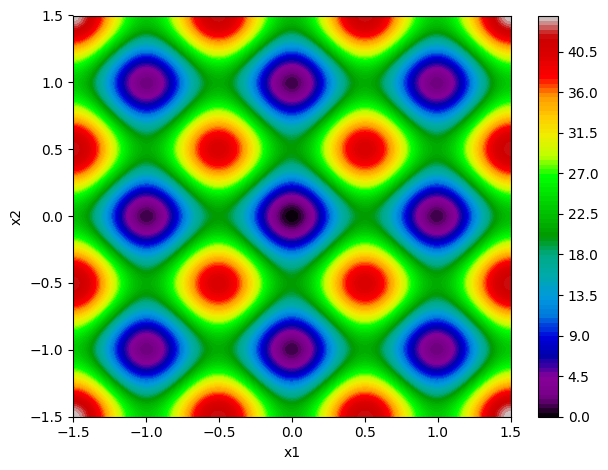

In [6]:
lb = -1.5
ub = 1.5
n = 2


def rastrigin_function(x: np.ndarray) -> float:
    x = np.asarray(x)
    n = len(x)
    return 10 * n + np.sum(x * x - (10 * np.cos(2 * math.pi * x)))


def plot_landscape(
    objective_function: callable, history: list = None, delta: float = 0.025
):
    """Convenience function to plot a 2D objective function landscape

    Parameters
    ----------
    objective_function: callable
        A callable which takes a list/array of real numbers and returns a floating point value
    history: list = None
        A list of points that should be plotted in addition to the contour.
    delta: float
        The precision of the plot
    """

    x = np.arange(lb, ub + delta, delta)
    y = np.arange(lb, ub + delta, delta)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros(X.shape)
    for idx1 in range(X.shape[0]):
        for idx2 in range(X.shape[1]):
            Z[idx1, idx2] = objective_function([X[idx1, idx2], Y[idx1, idx2]])

    plt.contourf(X, Y, Z, levels=100, cmap="nipy_spectral")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.colorbar()
    plt.tight_layout()

    if history is not None:
        history = np.asarray(history)
        x_best = np.argmin(history[:, 2])
        plt.scatter(history[:, 0], history[:, 1], alpha=0.6)
        plt.scatter(
            history[x_best, 0],
            history[x_best, 1],
            color="chartreuse",
            label=r"$x_{best}: f(x) = $" + f"{history[x_best, 2]: .3f}",
            s=50,
        )
        plt.legend()


# plot the rastrigin function landscape
plot_landscape(rastrigin_function)

## Starting point: a random local search algorithm

The starting point today will be the local random search algorithm from last week. 

In [3]:
history = []
for _ in range(1000):
    x = np.random.uniform(lb, ub, size=n)
    f = rastrigin_function(x)
    history.append(np.r_[x, f])

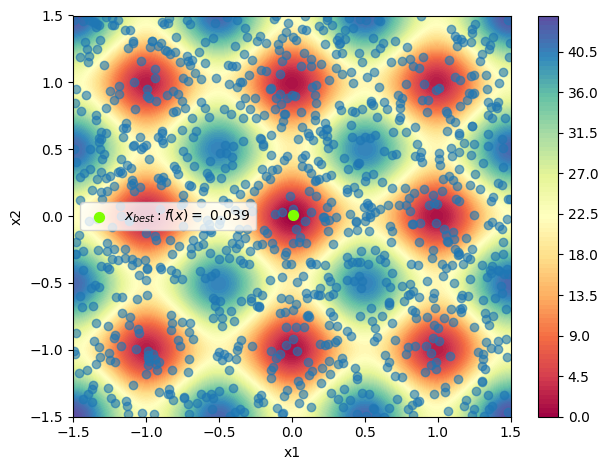

In [4]:
# plot the search process with in the contour plot by passing the history as a second parameter
plot_landscape(rastrigin_function, history)

## Step 1: Use basic mutation

We can modify our random search to not sample new points uniformly, but instead mutate the current best point slightly. As we have seen in the slides, mutation in evolution strategies permutes the current search point $\mathbf{x}^t$ by a normal distribution with zero mean and step size $\sigma$:

$\mathbf{x}^{t+1} = \mathbf{x}^t + \mathcal{N}(\mathbf{0}, \sigma)$.

For now, we'll fix the value of $\sigma$ to $||ub - lb|| / \sqrt{n}$, where $n$ is the dimension (2) and $||\cdot||$ denotes the euclidian norm, which is implemented by the numpy function ```np.linalg.norm```. 

Additionally, be sure to set an initial value of $x^t$, such that the update rule can be defined. We can do this uniformly. 

Similar to the uniform distribution, the method for using a normal (=Gaussian) distribution, can also be found in the ```numpy.random. ``` module. 

One important thing to take into account here is that we want to ensure new candidates are still within our bounds. For this, you can use the ```clip``` function from numpy (or any other method to move a point back between the bounds).  

In [5]:
# Set a stepsize (sigma) value
sigma = np.linalg.norm(ub - lb) / np.sqrt(n)

# Set an initial value for x
x = np.random.uniform(lb, ub, size=n)

history = []
for _ in range(1000):
    # mutate with a normal dist.
    x = x + np.random.normal(0, sigma, size=n)
    # ensure x is within the bounds
    x = x.clip(lb, ub)

    f = rastrigin_function(x)
    history.append(np.r_[x, f])

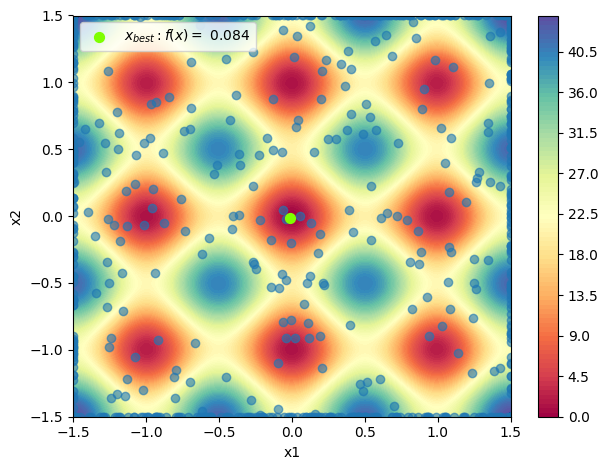

In [6]:
# plot the search behavior. Note how this differs from the random search example
plot_landscape(rastrigin_function, history)

## Step 2: Add a population of individuals
Since the evolution strategy is a population based algorithm, in this exercise we'll add a population of search points to the algorithm. The number of individuals in the population is denoted by the greek letter $\lambda$. Set this to 10 for now. 

We be implementing a simplified $(1, \lambda)$-ES in this exercise, which means that one of the $\lambda$ individuals should be kept as starting point for our next generation. We'll name this point $\mathbf{x}'$, which we initialize uniformly at random, similar to  $\mathbf{x}$ in the previous exersice. In our optimization loop, we set the $\mathbf{x}'$ to the mutated $\mathbf{x}_i$ which has the best (minimal) objective function value.

In order to do this, we need to keep track of the index of the current best solution within a generation. 


In [7]:
# Set a stepsize (sigma) value
sigma = np.linalg.norm(ub - lb) / np.sqrt(n)
# Set lambda
lamb = 10

# Set an initial value for x_prime
x_prime = np.random.uniform(lb, ub, size=n)

history = []
for _ in range(1000 // lamb):  # Reduce the number of iterations by a factor of lambda
    # add variables to keep track of population statistics
    f_best = np.inf
    best_idx = 0
    population = []

    # evaluate lambda solutions
    for i in range(lamb):
        xi = x_prime + np.random.normal(0, sigma, size=n)
        xi = xi.clip(lb, ub)
        fi = rastrigin_function(xi)

        # add to the population
        population.append([xi])

        # Keep track of the current best solution in our generation
        if fi < f_best:
            f_best = fi
            best_idx = i

        history.append(np.r_[xi, fi])

    # Update x_prime
    x_prime, *_ = population[best_idx]

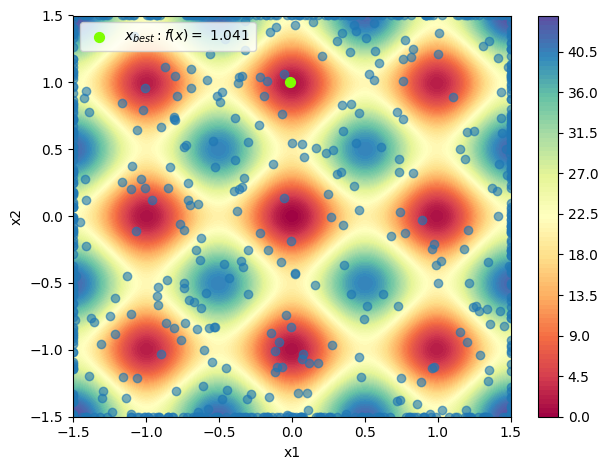

In [8]:
# plot the search behavior.
plot_landscape(rastrigin_function, history)

## Step 3: Self-adaptation

As discussed in the lecture, the defining property of evolution strategies is their ability for self-adaptation, that is, their ability to self-adapt their strategy parameters during optimization. 

As you probably noticed in the contour plot in the previous exercises, a great many of the sampled points were sampled out of bounds (and thus placed on the edge of the search domain by the clip function).

This is due to the fact that we used a static value for the strategy parameter $\sigma$, which remains large throughout the search process, and thus the algorithm is never able to change its search behaviour to be more localized. 

In this exercise we'll add self-adaptation for $\sigma$, to the code you previously implemented. The value of the step size $\sigma$ should be endogenous, which means that for each individual $\mathbf{x}_i$ we should have a *specific* $\sigma_i$ which is also mutated. After mutation, we set value of $\sigma'$ to the best mutated value of all $\sigma_i$, similar to how we set $\mathbf{x}'$ in the previous exercise. 

As shown in the slides, this changes the mutation to the following set of equations:

$\sigma_i = \sigma' \cdot \exp(\tau_0 \cdot \mathcal{N}(0,1))$

$\mathbf{x}_i = \mathbf{x}' + \mathcal{N}(\mathbf{0}, \sigma_i)$

Where the learning rate parameter $\tau_0 = \frac{1}{\sqrt{n}}$ according to Schwefel recommendation (see slides).

In [9]:
# Rename sigma to sigma_prime
sigma_prime = np.linalg.norm(ub - lb) / np.sqrt(n)

# Set lambda
lamb = 10
# define tau0
tau0 = 1 / np.sqrt(n)

# Set an initial value for x_prime
x_prime = np.random.uniform(lb, ub, size=n)

history = []
for _ in range(1000 // lamb):  # Reduce the number of iterations by a factor of lambda
    f_best = np.inf
    best_idx = 0
    population = []

    # evaluate lambda solutions
    for i in range(lamb):
        # mutate sigma_i for each individual
        si = sigma_prime * np.exp(tau0 * np.random.normal(0, 1))

        # mutate with a normal dist, be sure to use si and not sigma_prime
        xi = x_prime + np.random.normal(0, si, size=n)

        xi = xi.clip(lb, ub)
        fi = rastrigin_function(xi)

        # add to the population, also add si
        population.append([xi, si])

        # Keep track of the current best solution in our generation
        if fi < f_best:
            f_best = fi
            best_idx = i

        history.append(np.r_[xi, fi])

    # Update x_prime, sigma_prime
    x_prime, sigma_prime = population[best_idx]

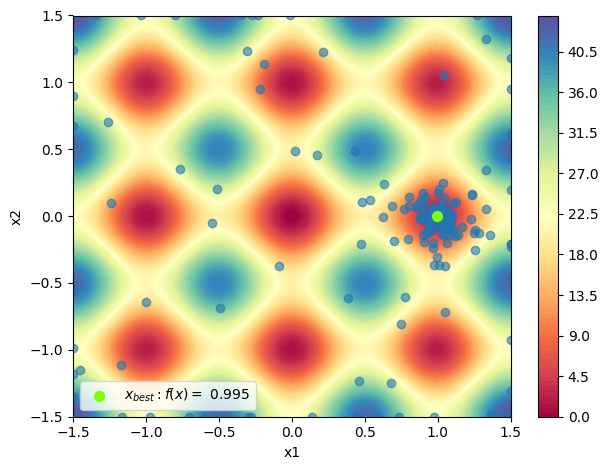

In [10]:
# plot the search behavior. Note how the behavoir has changed.
plot_landscape(rastrigin_function, history)

## Step 4: Selection and Recombination
For the case where $\mu > 1$, i.e. when we consider $\mu$ parents instead of only parent $\mathbf{x}'$ as was done up until now, we need a new way of generating offspring. We require a *recombination* operator, that takes the genetic information of two or more parents, and recomines that information into a single new offspring. 

In this exercise, we set the value of $\mu$ to 4, and implement local intermediate recombination between two parent solutions. This boils down to taking the arthimetic average between the values of two randomly selected parents. Note that in addition to taking the average $\mathbf{x}_i$ values, we should also take the arithmetic average of each $\sigma_i$. 

In order to determine which of the $\lambda$ offspring should be used as parents, we need to define a selection procedure. In evolution strategies, selection is deterministic, which is fancy way of saying that we simply take the $\mu$ best solutions of our generated offspring. Therefore, at the end of each generation, sort the population based on their function values (ascending), and take the first $\mu$ solutions as the next parent population. 

In [11]:
# Rename sigma_prime to sigma0
sigma0 = np.linalg.norm(ub - lb) / np.sqrt(n)

# Set lambda
lamb = 10
# Set mu
mu = 4

# define tau0
tau0 = 1 / np.sqrt(n)

# Set an initial value for the parent population
parent_population = [
    (np.random.uniform(lb, ub, size=n), sigma0, np.inf) for _ in range(mu)
]

history = []
for _ in range(1000 // lamb):  # Reduce the number of iterations by a factor of lambda
    population = []

    # evaluate lambda solutions
    for i in range(lamb):
        # Select two random parents
        p1, p2 = np.random.randint(0, mu, size=2)
        x1, s1, _ = parent_population[p1]
        x2, s2, _ = parent_population[p2]

        # Set the value of x_prime and sigma_prime to the arithmetic average of the values of parents
        x_prime = (x1 + x2) / 2
        sigma_prime = (s1 + s2) / 2

        # mutate sigma_i for each individual
        si = sigma_prime * np.exp(tau0 * np.random.normal(0, 1))

        # mutate with a normal dist, be sure to use si and not sigma_prime
        xi = x_prime + np.random.normal(0, si, size=n)

        xi = xi.clip(lb, ub)
        fi = rastrigin_function(xi)

        # add to the population, also add si and add fi
        population.append([xi, si, fi])
        history.append(np.r_[xi, fi])

    # sort the offspring population by function value
    population.sort(key=lambda x: x[2])

    # use the first mu offspring as the parent population
    parent_population = population[:mu].copy()

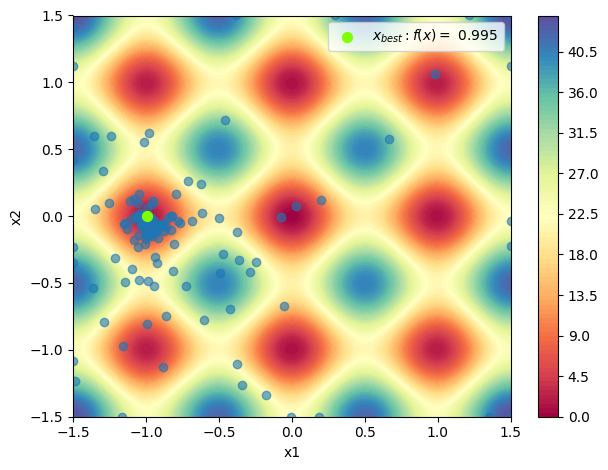

In [12]:
# plot the search behavior.
plot_landscape(rastrigin_function, history)

## Step 5: clean up the code and turn it into a class

Python is an object-oriented language, and thus using classes is quite common to allow our code to be easier to re-use. For more infomration on classes in python, please see: https://www.w3schools.com/python/python_classes.asp

We can now turn our ES-code into a class. 
We will make use of the default functions: ```__init__``` for initialization, which we can use to e.g. set a starting step size, and ```__call__``` for doing the optimization. This call function will get passed the objective function, and returns the history list. Try add member functions for the three operations: recombination, mutation and selection. 

It is up to you to decide where you pass in the variables relating to problem dimensionality and bounds. 

In [13]:
class EvolutionStrategy:
    def __init__(
        self, n=2, lb=-1.5, ub=1.5, n_evals=100, mu=4, lamb=10, sigma0=None, tau0=None
    ):
        self.n = n
        self.lb = lb
        self.ub = ub
        self.n_evals = n_evals
        self.lamb = lamb
        self.mu = mu
        self.sigma0 = sigma0 or np.linalg.norm(ub - lb) / np.sqrt(n)
        self.tau0 = tau0 or 1 / np.sqrt(n)

    def recombine(self, parent_population):
        p1, p2 = np.random.randint(0, self.mu, size=2)
        x1, s1, _ = parent_population[p1]
        x2, s2, _ = parent_population[p2]

        x_prime = (x1 + x2) / 2
        sigma_prime = (s1 + s2) / 2
        return x_prime, sigma_prime

    def mutate(self, x_prime, sigma_prime):
        si = sigma_prime * np.exp(self.tau0 * np.random.normal(0, 1))
        xi = x_prime + np.random.normal(0, si, size=self.n)
        xi = xi.clip(self.lb, self.ub)
        return xi, si
    
    def select(self, population):
        population.sort(key=lambda x: x[2])
        parent_population = population[:self.mu].copy()
        return parent_population

    def __call__(self, objective_function):
        parent_population = [
            (np.random.uniform(self.lb, self.ub, size=n), self.sigma0, np.inf) for _ in range(self.mu)
        ]

        history = []
        for _ in range(self.n_evals // self.lamb):
            population = []
            for _ in range(self.lamb):
                x_prime, sigma_prime = self.recombine(parent_population)
                xi, si = self.mutate(x_prime, sigma_prime)
                fi = objective_function(xi)  
                population.append([xi, si, fi])
                history.append(np.r_[xi, fi])
                
            parent_population = self.select(population)            
        return history

With the class defined, we can instantiate it to make an object which we can use to do the optimization, and easily experiment with other settings.

In [14]:
es = EvolutionStrategy(n_evals=1000, mu=5, lamb=20)

In [15]:
history = es(rastrigin_function)

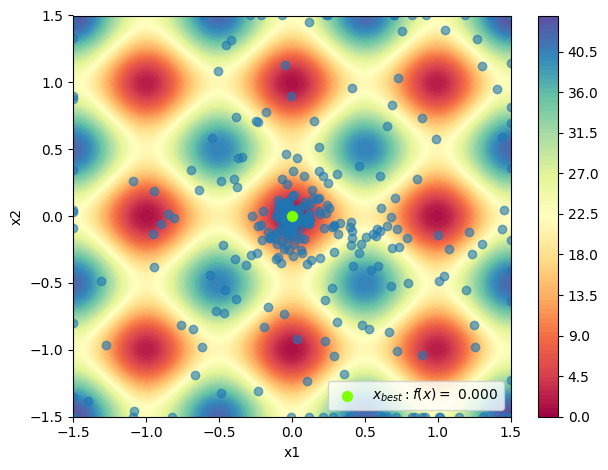

In [16]:
plot_landscape(rastrigin_function, history)

With this in place, we can now try different objective functions, run the algorithm multiple times on the same problem to see how different each run is, try different setting...
More information about the process of analyzing and comparing the performance of different optimization algorithms will follow in one of the next lectures.